In [1]:
%load_ext load_style
%load_style talk.css

# Compute and Plot ACW - Hovmoeller

* Hovmöller diagram
> A Hovmöller diagram is a commonly used way of plotting meteorological data to highlight the role of waves. The axes of a Hovmöller diagram are typically longitude or latitude (abscissa or x-axis) and time (ordinate or y-axis) with the value of some field represented through color or shading. Hovmöller diagrams are also used to plot the time evolution of vertical profiles of scalar quantities such as temperature, density, or concentrations of constituents in the atmosphere or ocean. In that case time is plotted along the abscissa and vertical position (depth, height, pressure) along the ordinate. The diagram was invented by Ernest Aabo Hovmöller (1912-2008), a Danish meteorologist, in a paper of 1949 (https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram).

* Antarctic Circumpolar Wave (ACW)
> The Antarctic Circumpolar Wave (ACW) is a coupled ocean/atmosphere wave that circles the Southern Ocean in approximately eight years at 6–8 cm/s (2.4–3.1 in/s). Since it is a wave-2 phenomenon (there are two ridges and two troughs in a latitude circle) at each fixed point in space a signal with a period of four years is seen. The wave moves eastward with the prevailing currents (https://en.wikipedia.org/wiki/Antarctic_Circumpolar_Wave).

## Data

Sometimes, we have to deal with GrADS data in grd format, a kind of binary file, which is commonly writtern in Fortran. Through the corresponding ctl file, we can get some basic information such as variables, time, units, etc.

If you are not familar with  GrADS data, there are some libraries to convert them into other formats, such as NetCDF format.

This time, we take the HadISST1.1 SST data during the period 1982 - 1999 as an example.

## 1. Load basic libs

In [2]:
% matplotlib inline

import numpy as np
import numpy.ma as ma
from scipy.signal import butter, lfilter, filtfilt

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 5, 10

## 2. Read HadISST1.1 SST data

### 2.1 Set file name

In [3]:
infile ='data/SST_19821999.T42.grd'

### 2.2 Set up basic info from ctl file

* resolution, number of years, undefined value

In [4]:
resol = [128, 64] # Resolution
itt   = 216       # Time series length
undef = -32768.0

ngrd = resol[0]*resol[1]

* lon & lat .. from ctl (lat in T42 grid)

In [5]:
lon = np.arange(0.0, 360.0, 2.81250) 
lat = np.array([ -87.86,-85.10, -82.31, -79.53, -76.74, -73.95,
-71.16, -68.37, -65.58, -62.79 ,-60.00, -57.21,
-54.42, -51.63, -48.84, -46.04, -43.25, -40.46,
-37.67, -34.88, -32.09, -29.30, -26.51, -23.72,
-20.93, -18.14, -15.35, -12.56, -9.77, -6.98,
-4.19, -1.40, 1.40, 4.19, 6.98, 9.77,
12.56, 15.35, 18.14, 20.93, 23.72, 26.51,
29.30, 32.09, 34.88, 37.67, 40.46, 43.25,
46.04, 48.84, 51.63, 54.42, 57.21, 60.00,
62.79, 65.58, 68.37, 71.16, 73.95, 76.74,
79.53, 82.31, 85.10, 87.86])

[X, Y] = np.meshgrid(lon, lat)

### 2.3 Load HadISST1.1 SST grd data

> Note: use numpy.fromfile to read the file, and specify that the type is big-endian specifying in the dtype parameter:

In [6]:
var = np.zeros( (ngrd,itt) )
with open(infile,'rb') as f:
    for k in xrange(itt):
        data = np.fromfile(f, dtype='>f', count=ngrd)
        var[:,k] = data  
var = var.reshape( (ngrd, itt) )
var.shape

(8192L, 216L)

### 2.5 undef -> nan 

In [7]:
var[var==undef] = np.nan

### 2.4 Weight by cos(lat) 

In [8]:
fcos = np.cos(Y*3.14/180.0)
fcos = fcos.T
fcos = fcos.reshape (ngrd, 1, order="F") 

num_repeats = itt
fcos = np.hstack([fcos]*num_repeats)#, axis=-1) # 8192*216 
var = var*fcos

## 3. Calculate anomaly 

In [9]:
sst          = var.reshape((resol[0],resol[1],itt), order="F")    # 128x64x216 
sst56s       = sst[:,11,:]                             # lat(11)= -57.21 ~= -56   % 128x216 
sst56s_m     = sst56s.reshape( (resol[0],12,itt/12), order="F" )  # 128x12x18 
sst56s_clima = np.mean(sst56s_m, axis=2);           # 128x12 
 
num_repeats    = itt/12
sst56s_clima_r = np.stack([sst56s_clima]*num_repeats, axis=-1) # 128x12x18 
sst56s_anoma   = sst56s_m-sst56s_clima_r;                      # 128x12x18 
sst56s_anoma_r = sst56s_anoma.reshape( (resol[0],12*itt/12), order="F")  # 128x216 

## 4. Band pass filtering 3 - 7 months 

In [10]:
[b, a] = butter(1., [ 1/7.,1/3. ],'stop')
#y      = lfilter(b, a, sst56s_anoma_r)
y      = filtfilt(b, a, sst56s_anoma_r)

## 5. Plot ACW Hovmoeller 

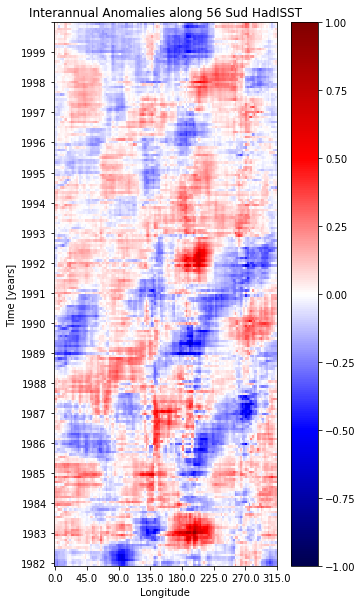

In [11]:
fig, ax = plt.subplots()
im = ax.pcolormesh(y.T,  cmap='seismic', vmin=-1., vmax=1.)
fig.colorbar(im)

ax.set_title('Interannual Anomalies along 56 Sud HadISST', fontsize=12)
ax.set_yticks(np.linspace(1,216,19))
ax.set_yticklabels(np.linspace(1982,1999,18, dtype=np.int))
ax.set_ylabel('Time [years]')
ax.set_xticks(np.linspace(1,128,8))
ax.set_xticklabels(lon[0:128:16])
ax.set_xlabel('Longitude')

## References

http://unidata.github.io/netcdf4-python/

Matplotlib: A 2D Graphics Environment by J. D. Hunter In Computing in Science & Engineering, Vol. 9, No. 3. (2007), pp. 90-95

Jones E, Oliphant E, Peterson P, et al. SciPy: Open Source Scientific Tools for Python, 2001-, http://www.scipy.org/ [Online; accessed 2017-09-11]

Hovmöller, E. (1949), The Trough-and-Ridge diagram. Tellus, 1: 62–66.

Rayner, N. A.; Parker, D. E.; Horton, E. B.; Folland, C. K.; Alexander, L. V.; Rowell, D. P.; Kent, E. C.; Kaplan, A. (2003) Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century J. Geophys. Res.Vol. 108, No. D14, 4407 10.1029/2002JD002670

White, W. B.; Peterson, R. G. (1996). "An Antarctic circumpolar wave in surface pressure, temperature and sea-ice extent" (PDF). Nature. 380: 699–702. Bibcode:1996Natur.380..699W. doi:10.1038/380699a0.

Jacobs, G. A.; Mitchell, J. L. (1996). "Ocean circulation variations associated with the Antarctic Circumpolar Wave" (PDF). Geophysical Research Letters. 23 (21): 2947–50. Bibcode:1996GeoRL..23.2947J. doi:10.1029/96GL02492. Retrieved May 2015.

Connolley, W. M. (2002). "Long-term variation of the Antarctic Circumpolar Wave". Journal of Geophysical Research. 107 (C4). Bibcode:2002JGRC..107.8076C. doi:10.1029/2000JC000380.